# พลอตเรดาร์ฝนโมเสครายชั่วโมง 8 ภาพ 

C:\Users\Admin\AppData\Local\Temp\ipykernel_2428\276884600.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


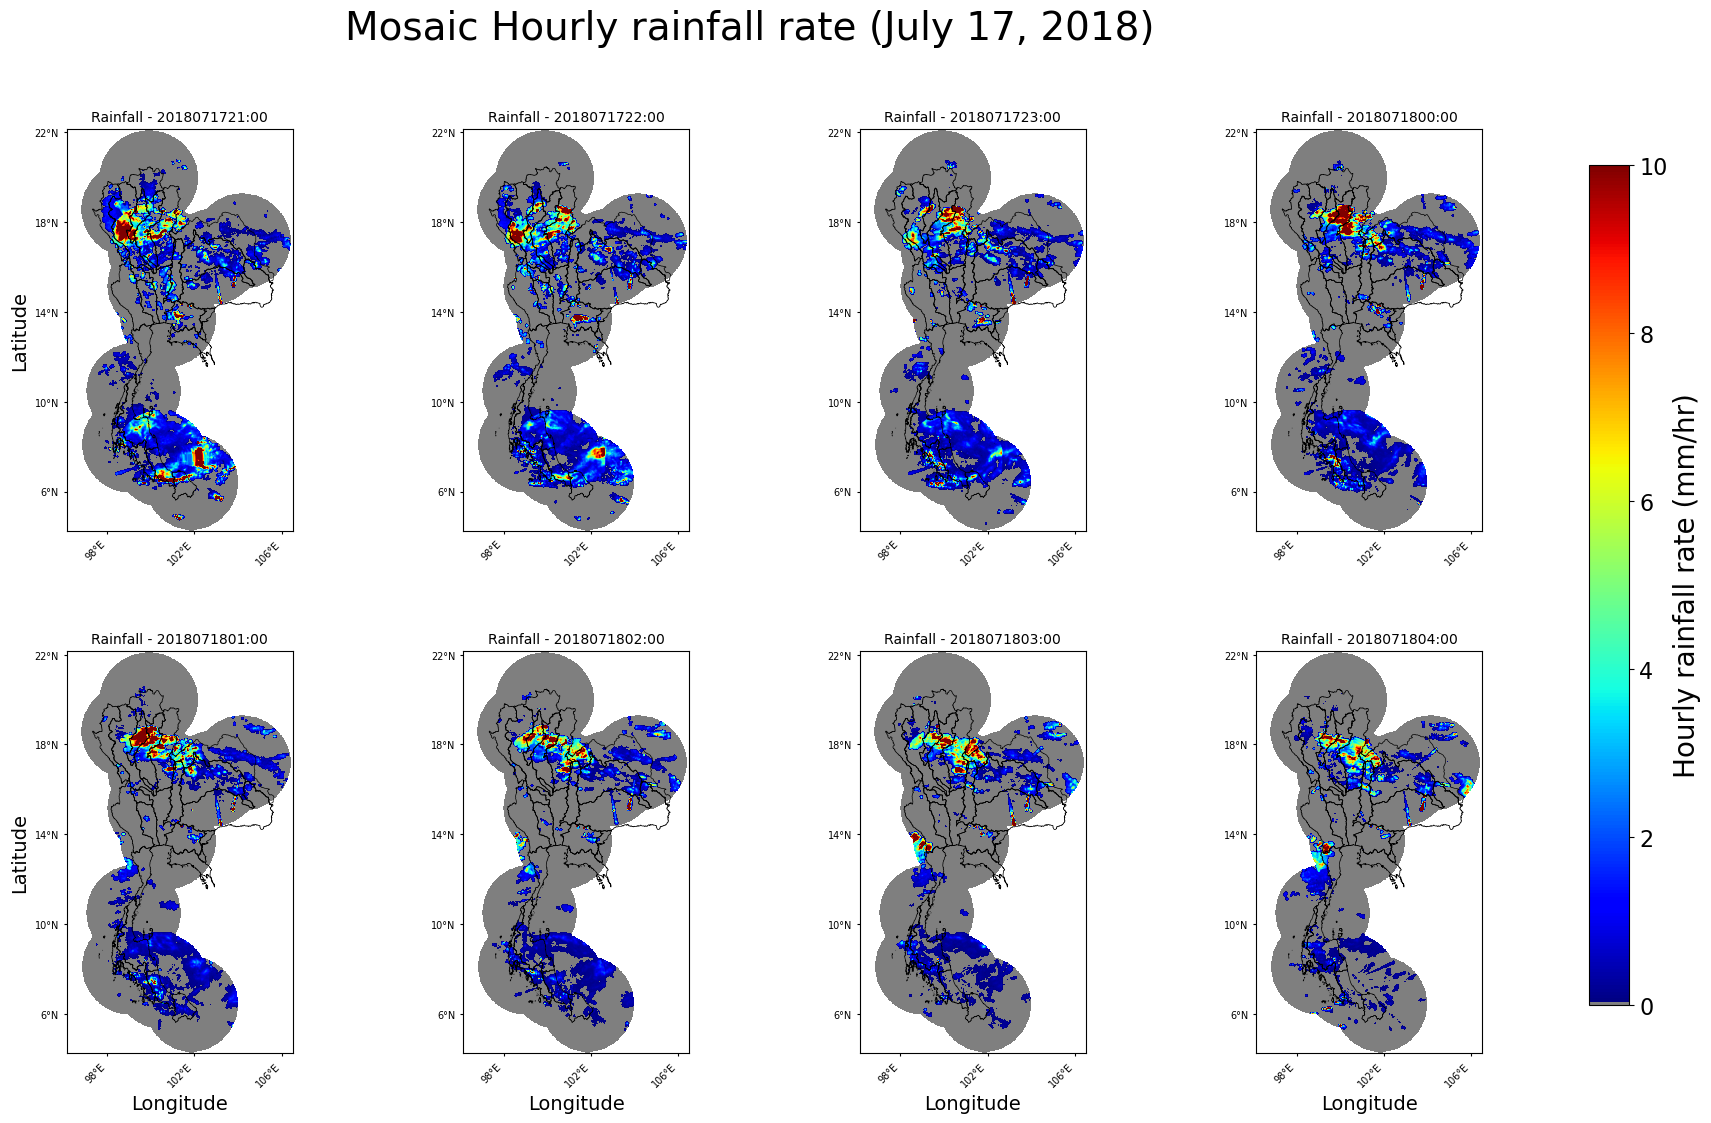

In [1]:
'''
2024.09.22
โค้ดนี้พัฒนาโดย รองศาสตราจารย์ ดร. นัฐพล มหาวิค ภาควิชาทรัพยากรธรรมชาติและสิ่งแวดล้อม คณะเกษตรศาสตร์ฯ มหาวิทยาลัยนเรศวร 
ในงานวิจัย เรื่อง "การวิจัยและพัฒนาผลิตภัณฑ์โมเสคฝนประมาณค่าจากเรดาร์ตรวจอากาศในพื้นที่ระดับลุ่มน้ำของประเทศไทยด้วยเทคโนโลยีภูมิสารสนเทศรหัสเปิด"
สนับสนุนทุนวิจัยโดยสํานักงานการวิจัยแห่งชาติ (วช.)  แผนงานการวิจัยและนวัตกรรมแผนงานด้านการบริหารจัดการภัยพิบัติทางธรรมชาติ 
ประจำปีงบประมาณ 2566  ตามสัญญา เลขที่ N25A660467 ผู้นำโค้ดนี้ไปใช้หรือดัดแปลงควรอ้างอิงงานวิจัยชิ้นนี้ตามหลักเกณฑ์การอ้างอิงสากล
เรียนหลักการเรดาร์และภูมิสารสนเทศ ที่ https://www.youtube.com/@Nattapon_Mahavik/playlists
หนังสือเรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/144567
หนังสือออนไลน์เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/205129
ติดต่อ nattaponm@nu.ac.th
'''
# โค้ดสมบูรณ์แบบพลอต8ภาพ ให้ค่าชั่วโมงแรกแล้วจะพลอตอีก 7 ภาพต่อมาเอง 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Geod
from datetime import datetime, timedelta
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec

def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

def read_mosaic_report(report_path):
    df = pd.read_csv(report_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')  # Changed to hour precision
    df['available_radars'] = df['available_radars'].apply(lambda x: x.split(','))
    return df

def create_geodetic_radar_buffers(radar_dict, active_radars, radius_km, crs):
    geod = Geod(ellps="WGS84")
    azimuths = np.linspace(0, 360, 361)
    
    radar_data = [
        {'radar': radar, 'geometry': Polygon([
            geod.fwd(*radar_dict[radar]['coords'][:2], azimuth, radius_km * 1000)[:2]
            for azimuth in azimuths
        ])}
        for radar in active_radars
    ]
    
    return gpd.GeoDataFrame(radar_data, crs=crs)

def create_radar_mask(radar_buffers, shape, transform, crs):
    return rasterize(
        [(geom, 1) for geom in radar_buffers.geometry],
        out_shape=shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

def plot_multiple_rainfall_maps(data_list, mask_list, transform_list, crs_list, basin_shapefile, time_list, vmin=0, vmax=10):
    fig = plt.figure(figsize=(20, 12))  # Increased figure size
    #gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.05, hspace=0.1)
    gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.1, hspace=0.3)  # Increased vertical space

    cmap = plt.cm.jet
    jet_colors = cmap(np.linspace(0, 1, 256))
    jet_colors[0] = [0.5, 0.5, 0.5, 1]  # Set first color (0 mm) to grey
    custom_cmap = ListedColormap(jet_colors)
    custom_cmap.set_bad('white')  # For NaN values (outside radar mask)

    gdf = gpd.read_file(basin_shapefile)

    for i, (data, mask, transform, crs, time_hr) in enumerate(zip(data_list, mask_list, transform_list, crs_list, time_list)):
        ax = fig.add_subplot(gs[i // 4, i % 4])
        masked_data = np.ma.masked_where(mask == 0, data)
        
        extent = rasterio.transform.array_bounds(data.shape[0], data.shape[1], transform)
        extent = [extent[0], extent[2], extent[1], extent[3]]

        im = ax.imshow(masked_data, cmap=custom_cmap, extent=extent, origin='upper', vmin=vmin, vmax=vmax)
        gdf.to_crs(crs).boundary.plot(ax=ax, color='black', linewidth=0.5)

        ax.set_title(f'Rainfall - {time_hr}:00', fontsize=10)
        ax.set_xlim(96.15, 106.5)
        ax.set_ylim(4.25, 22.15)

        # Set custom tick locations and labels
        lon_ticks = [98, 102, 106]
        lat_ticks = [6, 10, 14, 18, 22]
        
        ax.xaxis.set_major_locator(FixedLocator(lon_ticks))
        ax.xaxis.set_major_formatter(FixedFormatter([f'{x}°E' for x in lon_ticks]))
        ax.yaxis.set_major_locator(FixedLocator(lat_ticks))
        ax.yaxis.set_major_formatter(FixedFormatter([f'{y}°N' for y in lat_ticks]))

        ax.tick_params(axis='both', which='major', labelsize=7)

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Remove tick marks
        ax.tick_params(axis='both', which='both', length=2)


        if i % 4 == 0:
            ax.set_ylabel("Latitude", fontsize=14)  # Doubled font size
        #else:
        #    ax.set_yticklabels([])

        if i // 4 == 1:
            ax.set_xlabel("Longitude", fontsize=14)  # Doubled font size
        #else:
        #    ax.set_xticklabels([])

        #ax.tick_params(axis='both', which='both', length=1, labelsize=14)  # Doubled font size

    # Add a single colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Hourly rainfall rate (mm/hr)", fontsize=20)  # Doubled font size
    cbar.ax.tick_params(labelsize=16)  # Doubled font size

    initial_datetime = datetime.strptime(time_list[0], "%Y%m%d%H")
    plt.suptitle(f"Mosaic Hourly rainfall rate ({initial_datetime.strftime('%B %d, %Y')})", fontsize=28, y=0.98)  # Doubled font size
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()   

def main(initial_hour, base_dir, basin_shapefile, mosaic_report_path, radar_dict, radius_km=240):
    mosaic_report = read_mosaic_report(mosaic_report_path)
    
    initial_dt = datetime.strptime(initial_hour, '%Y%m%d%H')
    time_list = [(initial_dt + timedelta(hours=i)).strftime('%Y%m%d%H') for i in range(8)]
    
    data_list, mask_list, transform_list, crs_list = [], [], [], []
    
    for time_hr in time_list:
        file_path = os.path.join(base_dir, f"{time_hr}.tif")
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        time_hr_dt = pd.to_datetime(time_hr, format='%Y%m%d%H')
        matching_row = mosaic_report[mosaic_report['timestamp'] == time_hr_dt]
        
        if matching_row.empty:
            print(f"No data found for timestamp {time_hr} in the mosaic report.")
            continue
        
        available_radars = matching_row['available_radars'].iloc[0]
        
        if not available_radars:
            print(f"No available radars for timestamp {time_hr}")
            continue
        
        data, transform, crs = read_geotiff(file_path)
        radar_buffers = create_geodetic_radar_buffers(radar_dict, available_radars, radius_km, crs)
        radar_mask = create_radar_mask(radar_buffers, data.shape, transform, crs)
        
        data_list.append(data)
        mask_list.append(radar_mask)
        transform_list.append(transform)
        crs_list.append(crs)
    
    plot_multiple_rainfall_maps(data_list, mask_list, transform_list, crs_list, basin_shapefile, time_list)

if __name__ == "__main__":
    radar_dict = {
        "CHN": {'coords': (100.191263, 15.157852, 40.0), 'el': 0.5},
        "CMP": {'coords': (99.188203, 10.493099, 32.0), 'el': 0.0},
        "CRI": {'coords': (99.881593, 19.961471, 444.0), 'el': 1.08},
        "KKN": {'coords': (102.785881, 16.4625, 217.0), 'el': 0.42},
        "KRB": {'coords': (98.97806, 8.101389, 52.0), 'el': 0.8},
        "LMP": {'coords': (99.038728, 18.566602, 328.0), 'el': 1.67},
        "NRT": {'coords': (101.825165, 6.426888, 33.0), 'el': 0.5},
        "NAN": {'coords': (100.788902, 19.124102, 260.0), 'el': 1.41},
        "PHS": {'coords': (100.217964, 16.775408, 72.0), 'el': 0.5},
        "PKT": {'coords': (98.329462, 8.133407, 281.0), 'el': 0.02},
        "SNK": {'coords': (104.132591, 17.156363, 196.0), 'el': 0.42},
        "STP": {'coords': (100.459996, 7.449996, 33.0), 'el': 0.5},
        "SVP": {'coords': (100.766541, 13.684727, 39.0), 'el': 1.5},
        "URT": {'coords': (104.870004, 15.245, 157.0), 'el': 0.41},
    } 

    BASE_DIR = "../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/0no_mfb"
    BASIN_SHAPEFILE = "../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp"
    MOSAIC_REPORT_PATH = '../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/mosaic_report.csv'

    TIME_HR = "2018071721" #เลือกเวลาเริ่มต้นตรงนี้

    main(TIME_HR, BASE_DIR, BASIN_SHAPEFILE, MOSAIC_REPORT_PATH, radar_dict)

# โค้ดสมบูรณ์แบบพลอตผลโมเสคเดี่ยว

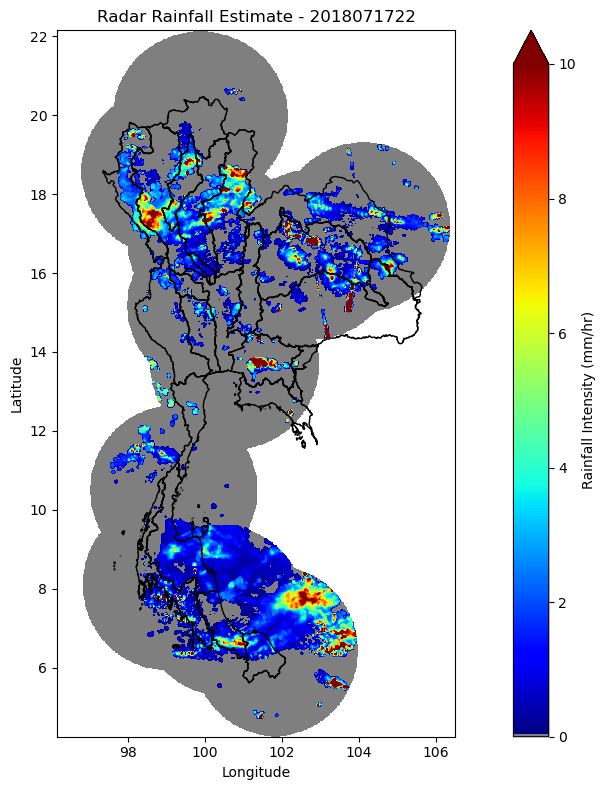

In [4]:
# โค้ดสมบูรณ์แบบพลอตผลโมเสคเดี่ยว
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Geod

def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

def read_mosaic_report(report_path):
    df = pd.read_csv(report_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')  # Changed to hour precision
    df['available_radars'] = df['available_radars'].apply(lambda x: x.split(','))
    return df

def create_geodetic_radar_buffers(radar_dict, active_radars, radius_km, crs):
    geod = Geod(ellps="WGS84")
    azimuths = np.linspace(0, 360, 361)
    
    radar_data = [
        {'radar': radar, 'geometry': Polygon([
            geod.fwd(*radar_dict[radar]['coords'][:2], azimuth, radius_km * 1000)[:2]
            for azimuth in azimuths
        ])}
        for radar in active_radars
    ]
    
    return gpd.GeoDataFrame(radar_data, crs=crs)

def create_radar_mask(radar_buffers, shape, transform, crs):
    return rasterize(
        [(geom, 1) for geom in radar_buffers.geometry],
        out_shape=shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

def plot_rainfall_map(data, radar_mask, transform, crs, basin_shapefile, time_hr, vmin=0, vmax=10):
    cmap = plt.cm.jet
    jet_colors = cmap(np.linspace(0, 1, 256))
    jet_colors[0] = [0.5, 0.5, 0.5, 1]  # Set first color (0 mm) to grey
    custom_cmap = ListedColormap(jet_colors)
    custom_cmap.set_bad('white')  # For NaN values (outside radar mask)

    masked_data = np.ma.masked_where(radar_mask == 0, data)

    fig, ax = plt.subplots(figsize=(12, 8))
    extent = rasterio.transform.array_bounds(data.shape[0], data.shape[1], transform)
    extent = [extent[0], extent[2], extent[1], extent[3]]

    im = ax.imshow(masked_data, cmap=custom_cmap, extent=extent, origin='upper', vmin=vmin, vmax=vmax)

    gdf = gpd.read_file(basin_shapefile)
    gdf.to_crs(crs).boundary.plot(ax=ax, color='black', linewidth=1)

    plt.colorbar(im, ax=ax, extend='max', label='Rainfall Intensity (mm/hr)')
    ax.set_title(f'Radar Rainfall Estimate - {time_hr}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(96.15, 106.5)
    ax.set_ylim(4.25, 22.15)
    
    plt.tight_layout()
    plt.show()

def main(time_hr, base_dir, basin_shapefile, mosaic_report_path, radar_dict, radius_km=240):
    file_path = os.path.join(base_dir, f"{time_hr}.tif")
    mosaic_report = read_mosaic_report(mosaic_report_path)
    
    time_hr_dt = pd.to_datetime(time_hr, format='%Y%m%d%H')
    
    # Find the matching row in the mosaic report
    matching_row = mosaic_report[mosaic_report['timestamp'] == time_hr_dt]
    
    if matching_row.empty:
        print(f"No data found for timestamp {time_hr} in the mosaic report.")
        return
    
    available_radars = matching_row['available_radars'].iloc[0]
    
    if not available_radars:
        print(f"No available radars for timestamp {time_hr}")
        return
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    data, transform, crs = read_geotiff(file_path)
    radar_buffers = create_geodetic_radar_buffers(radar_dict, available_radars, radius_km, crs)
    radar_mask = create_radar_mask(radar_buffers, data.shape, transform, crs)
    
    plot_rainfall_map(data, radar_mask, transform, crs, basin_shapefile, time_hr)

if __name__ == "__main__":
    radar_dict = {
        "CHN": {'coords': (100.191263, 15.157852, 40.0)},
        "CMP": {'coords': (99.188203, 10.493099, 32.0)},
        "CRI": {'coords': (99.881593, 19.961471, 444.0)},
        "KKN": {'coords': (102.785881, 16.4625, 217.0)},
        "KRB": {'coords': (98.97806, 8.101389, 52.0)},
        "LMP": {'coords': (99.041701, 18.565399, 320.0)},
        "NRT": {'coords': (101.825165, 6.426888, 33.0)},
        "PHS": {'coords': (100.217964, 16.775408, 72.0)},
        "PKT": {'coords': (98.329444, 8.133611, 281.0)},
        "SNK": {'coords': (104.132591, 17.156363, 196.0)},
        "STP": {'coords': (100.459996, 7.449996, 33.0)},
        "SVP": {'coords': (100.7675, 13.686389, 28.0)},
    }

    BASE_DIR = "../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/0mfb"
    BASIN_SHAPEFILE = "../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp"
    MOSAIC_REPORT_PATH = '../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/mosaic_report.csv'

    TIME_HR = "2018071722"

    main(TIME_HR, BASE_DIR, BASIN_SHAPEFILE, MOSAIC_REPORT_PATH, radar_dict)

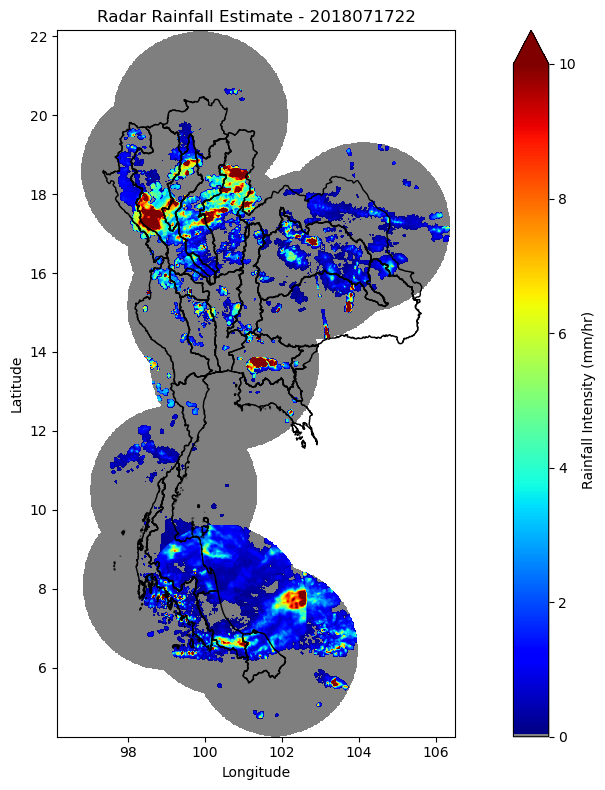

In [1]:
# โค้ดสมบูรณ์แบบพลอตผลโมเสคเดี่ยว
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Geod

def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

def read_mosaic_report(report_path):
    df = pd.read_csv(report_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')  # Changed to hour precision
    df['available_radars'] = df['available_radars'].apply(lambda x: x.split(','))
    return df

def create_geodetic_radar_buffers(radar_dict, active_radars, radius_km, crs):
    geod = Geod(ellps="WGS84")
    azimuths = np.linspace(0, 360, 361)
    
    radar_data = [
        {'radar': radar, 'geometry': Polygon([
            geod.fwd(*radar_dict[radar]['coords'][:2], azimuth, radius_km * 1000)[:2]
            for azimuth in azimuths
        ])}
        for radar in active_radars
    ]
    
    return gpd.GeoDataFrame(radar_data, crs=crs)

def create_radar_mask(radar_buffers, shape, transform, crs):
    return rasterize(
        [(geom, 1) for geom in radar_buffers.geometry],
        out_shape=shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

def plot_rainfall_map(data, radar_mask, transform, crs, basin_shapefile, time_hr, vmin=0, vmax=10):
    cmap = plt.cm.jet
    jet_colors = cmap(np.linspace(0, 1, 256))
    jet_colors[0] = [0.5, 0.5, 0.5, 1]  # Set first color (0 mm) to grey
    custom_cmap = ListedColormap(jet_colors)
    custom_cmap.set_bad('white')  # For NaN values (outside radar mask)

    masked_data = np.ma.masked_where(radar_mask == 0, data)

    fig, ax = plt.subplots(figsize=(12, 8))
    extent = rasterio.transform.array_bounds(data.shape[0], data.shape[1], transform)
    extent = [extent[0], extent[2], extent[1], extent[3]]

    im = ax.imshow(masked_data, cmap=custom_cmap, extent=extent, origin='upper', vmin=vmin, vmax=vmax)

    gdf = gpd.read_file(basin_shapefile)
    gdf.to_crs(crs).boundary.plot(ax=ax, color='black', linewidth=1)

    plt.colorbar(im, ax=ax, extend='max', label='Rainfall Intensity (mm/hr)')
    ax.set_title(f'Radar Rainfall Estimate - {time_hr}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(96.15, 106.5)
    ax.set_ylim(4.25, 22.15)
    
    plt.tight_layout()
    plt.show()

def main(time_hr, base_dir, basin_shapefile, mosaic_report_path, radar_dict, radius_km=240):
    file_path = os.path.join(base_dir, f"{time_hr}.tif")
    mosaic_report = read_mosaic_report(mosaic_report_path)
    
    time_hr_dt = pd.to_datetime(time_hr, format='%Y%m%d%H')
    
    # Find the matching row in the mosaic report
    matching_row = mosaic_report[mosaic_report['timestamp'] == time_hr_dt]
    
    if matching_row.empty:
        print(f"No data found for timestamp {time_hr} in the mosaic report.")
        return
    
    available_radars = matching_row['available_radars'].iloc[0]
    
    if not available_radars:
        print(f"No available radars for timestamp {time_hr}")
        return
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    data, transform, crs = read_geotiff(file_path)
    radar_buffers = create_geodetic_radar_buffers(radar_dict, available_radars, radius_km, crs)
    radar_mask = create_radar_mask(radar_buffers, data.shape, transform, crs)
    
    plot_rainfall_map(data, radar_mask, transform, crs, basin_shapefile, time_hr)

if __name__ == "__main__":
    radar_dict = {
        "CHN": {'coords': (100.191263, 15.157852, 40.0)},
        "CMP": {'coords': (99.188203, 10.493099, 32.0)},
        "CRI": {'coords': (99.881593, 19.961471, 444.0)},
        "KKN": {'coords': (102.785881, 16.4625, 217.0)},
        "KRB": {'coords': (98.97806, 8.101389, 52.0)},
        "LMP": {'coords': (99.041701, 18.565399, 320.0)},
        "NRT": {'coords': (101.825165, 6.426888, 33.0)},
        "PHS": {'coords': (100.217964, 16.775408, 72.0)},
        "PKT": {'coords': (98.329444, 8.133611, 281.0)},
        "SNK": {'coords': (104.132591, 17.156363, 196.0)},
        "STP": {'coords': (100.459996, 7.449996, 33.0)},
        "SVP": {'coords': (100.7675, 13.686389, 28.0)},
    }

    BASE_DIR = "../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/0no_mfb/"
    BASIN_SHAPEFILE = "../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp"
    MOSAIC_REPORT_PATH = '../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_dbz_single/0mosaic/2max_mos/0mosaics/mosaic_report.csv'

    TIME_HR = "2018071722"

    main(TIME_HR, BASE_DIR, BASIN_SHAPEFILE, MOSAIC_REPORT_PATH, radar_dict)